In [1]:
from IPython.core.display import HTML
css_file = './numericalmoocstyle.css'
HTML(open(css_file, "r").read())

In [2]:
import numpy
from numpy import pi
#
import sympy
import math
#
import scipy
from scipy import constants
#
import matplotlib.pyplot 
#
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
%matplotlib inline
#
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
#
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

### Domain

In [3]:
def get_domain(Ld, n_gap):
    ''' This function obtains the domain based on a 
    staggered grid. The domain is divided into three parts:
    (1) anode region, (2) gap, (3) cathode.
    
    Parameters:
    ----------
    Ld: Domain Length
    n_gap: number of boundary nodes in gap
    
    Returns:
    --------
    '''
    #staggered grid approach
    #gap region
    xl_gap = 0.0
    xr_gap = Ld
    delx_gap = (xr_gap-xl_gap)/(n_gap-1.0)
    xb_gap = numpy.linspace(xl_gap, xr_gap, n_gap)
    xc_gap = xb_gap[:-1]+(delx_gap*0.5)
    #
    #
    return delx_gap, xb_gap, xc_gap
    

In [4]:
# Domain, Dimensions
L_chamber = 0.24  #meters
Lgap = 0.004 #interelectrode gap [meters]
L_cathode = 0.112
L_anode = L_chamber - (Lgap + L_cathode)
#
nx_anode = 101
nx_cathode = 111
nx_gap = 121
#
Rc = (12.5/2.) * 1./1000. # cathode radius [meters]
Ran = 6.35/2. * 1./1000.  #anode radius [meters]

#get cell boundary and cell center locations
dx, xb, xc = get_domain(Lgap,nx_gap)
#
l2_target = 1e-7
#
#time step
dt = 0.000015 # {sec} time step

In [5]:
numpy.shape(xb)

(121,)

In [6]:
numpy.shape(xc)

(120,)

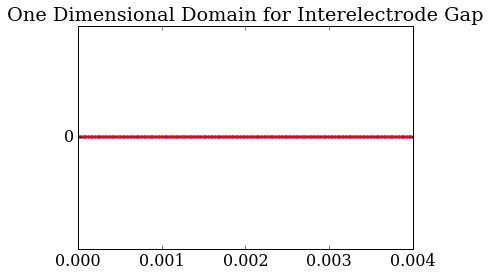

In [7]:
Xc_gap = numpy.meshgrid(xc)
Xb_gap = numpy.meshgrid(xb)
#
pyplot.title('One Dimensional Domain for Interelectrode Gap')
pyplot.ylim(-.0002,0.0002)
pyplot.xlim(0., Lgap)
pyplot.scatter(Xb_gap,numpy.zeros_like(Xb_gap),\
                   s=10, color='b', marker='o', linewidth=0)
pyplot.scatter(Xc_gap,numpy.zeros_like(Xc_gap), \
                   s=10, color='r', marker='o', linewidth=0)
pyplot.xticks(numpy.arange(0, Lgap+0.001, 0.001))
pyplot.yticks(numpy.arange(0, 0.0002, 0.001));

Note that velocities are calculated on the cell boundaries (blue), and the pressure, density,electrical conductivity, potential, current density and temperature are calculated on the cell center (red)

### Initialization

In [8]:
def L2_error(p_new, p_old):
    '''This function computes the L2 norm of the error for convergence
    
    This function is used for convergence of the pressure equation

    Parameters:
    ----------
    p_new: new computed potential in flow field
    p_old: previous flow field potential
    
    Returns:
    ----------
    error!
    
    1:-1,1:-1
    '''
    
    return numpy.sqrt(numpy.sum((p_new[:] - p_old[:])**2)\
                      /numpy.sum(p_old[:]**2))

In [9]:
#Input Current
I_arc = 60.0

#Initialization Variables
gamma1 = 5.0/3.0
gravity = 9.81

# collision radius Carbon-Helium:
cr_C_He = (1.7 + 1.4)

#Constants
Ckb = scipy.constants.k  #Boltzmann Constant J/K
Cme = scipy.constants.m_e #Elementary Electron Mass kg
Ch = scipy.constants.h; # Planck's constant Js
CA = 1.2e6 #constant in electron current density eqn [A/(m^2 K^2)], pg.62

CNA = scipy.constants.N_A #avogadros number

Ce = scipy.constants.e #elementary charge, C

#Carbon
M_C = 12.0e-3/CNA #kg, mass of 1 atom of pure carbon
mC = 12.0107 # molar mass g/mol
Ips1 = 1086.5e3/CNA #J, energy of first ionization
anode_workfunction = 4.81 #eV
emissivity=0.70 #carbon, graphite
E_C = 11.2603*constants.e #ionization energy for carbon in Joules
R_C = 8314.0/mC #specific gas constant

#heat of vaporization anode:
dH_C = 710.0e6/mC
#
#Helium
M_He = 4.0e-3/CNA # kg, mass of 1 atom of Helium
mHe = 4.002602 #molar mass, g/mol
Ipg1 = 2372.3e3/CNA; # J, energy of first ionization

R_He = 8314.0/mHe #specific gas constant
#       

##### Initial Conditions

In [10]:
def get_initial_conditions(x1,x2,I_input,R_anode, phi_cathode):
    '''
    Defines initial variables 
    add two ghost cells to represent nodes on anode and cathode
    
    Parameters:
    -----------
    x1: boundary x locations
    x2: center cell x locations
    I_input: arc current input
    R_anode: anode radius
    
    Returns:
    -------
    jx:current density
    phi_x: electric potential
    cp_x: specific heat
    Tx: Temperature
    e_cond: electrical conductivity
    visc: viscosity
    k_cond: thermal conductivty
    ne_x: number density of electrons
    
    Assume vent conditions and that only anode is modeled
    '''
    Tref = 300.0
    #
    a = numpy.size(x1) + 2 #this is to add ghost cells, these are boundary cells
    b = numpy.size(x2) + 2 #this is to add ghost cells, these are center cells
    #------------------------------------------
    #grid 1 (cell edges)
    ux = numpy.zeros((a),dtype=float) #velocity
    #grid 2 cell centers-----------------------
    jx = numpy.zeros((b), dtype=float) #current density
    phi_x = numpy.zeros((b),dtype=float) #electric potential
    e_cond = numpy.zeros((b),dtype=float) #electrical conductivity
    rho_x = numpy.zeros((b),dtype=float) #density
    ne_x = numpy.zeros((b), dtype=float) #number density of electrons
    #
    cp_x = numpy.zeros((b),dtype=float) #specific heat
    Tx = numpy.zeros((b),dtype=float) #temperature
    visc = numpy.zeros((b),dtype=float) #viscosity
    k_cond = numpy.zeros((b),dtype=float) #thermal conductivity
    Px = numpy.zeros((b),dtype=float) # pressure
    hx = numpy.zeros((b),dtype=float) #enthalpy
    #
    Rs = numpy.zeros((b),dtype=float) # specific gas constant
    Rs[:] = 8314.0/mHe
    # 
    jx[0] = I_input/(numpy.pi*(R_anode**2)) #current density
    jx[1] = I_input/(numpy.pi*(R_anode**2))
    jx[2:] = I_input/(numpy.pi*(R_anode**2)) 
    # electric potential
    phi_x[:] = 0.0
    phi_x[-1] = 0.
    phi_x[-2] = 0.
    # specific heat
    cp_x[1:] = 5195. #J/(kg-K) of helium
    cp_x[0] = 710. #J/(kg-K) of carbon
    # temperature
    Tx[:] = 300.0 #kelvin # assume uniform temperature
    # viscosity
    visc[0] = 10. #Pa·s = kg/(s·m)
    visc[-1] = 19.0e-6 #10.
    visc[1:-1] = 19.0e-6
    # velocity, assume still
    ux[:] = 0. # m/s
    # thermal conductivity
    k_cond[2:] = 0.15 # W/(m-K)
    k_cond[0] = 110.
    k_cond[1] = 0.15 #110.
    # electrical conductivity
    e_cond[1:-1] = I_input # Siemens/meter
    e_cond[0] = I_input #1e-5
    e_cond[-1] = I_input #1e-5
    # number density of electrons
    ne_x[0] = 1e6 # 1/m3, number density of electrons
    ne_x[-1] = 1e6 
    ne_x[1:-1] = 1e6
    # density
    rho_x[0] = 0.164#2266 #graphite kg/m3
    rho_x[-1] = 0.164  #2266. #graphite
    rho_x[1:-1] = 0.164 #helium
    #
    #Px[:] = 0.5*(rho_x[1:]+rho_x[:-1])*Rs[:]*Tx[:] + 0.5*(ne_x[1:]+ne_x[:-1])*Ckb*Tx[:]
    Px[:] = (rho_x[:])*Rs[:]*Tx[:] + (ne_x[:])*Ckb*Tx[:]
    #
    hx[:] = cp_x[:]*(Tx[:]-Tref)
    #
    return jx, phi_x, cp_x, Tx, visc, ux, k_cond, rho_x, Px, hx, e_cond, ne_x

In [11]:
j0,phi0,cp0,T0,mu0,u0,k0,rho0,p0,h0,econd0, ne0 = \
    get_initial_conditions(xb,xc,I_arc,Ran, -10.0)

In [12]:
econd0[:10] 
#
#first ten values
# this is how the electrical conductivity is initialized (same as arc current)

array([ 60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.])

In [13]:
j0[:10] 
# these are the first ten values in the array
#this is the initial condition for current density (corresponfs to 60 amps everywhere)

array([ 1894584.23173439,  1894584.23173439,  1894584.23173439,
        1894584.23173439,  1894584.23173439,  1894584.23173439,
        1894584.23173439,  1894584.23173439,  1894584.23173439,
        1894584.23173439])

## there is constant current throughout the domain initially

In [14]:
ne0

array([ 1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000., 

##### reference values

In [15]:
# reference values are stored (n-1) time step,
# because they are used in the energy equation
pref = numpy.zeros_like(p0)
pref[:] = p0[1]
#
Tref = numpy.zeros_like(T0)
Tref[:] = 300.

In [16]:
def potential_algorithm(electrical_conductivity, center_nodes, delx):
    '''
    '''
    #
    xc_nodes = center_nodes.copy()
    x_an = xc_nodes[0]
    x_cath = xc_nodes[-1]
    #
    array_size = electrical_conductivity.size 
    #
    A = numpy.zeros_like(electrical_conductivity)
    B = numpy.zeros_like(electrical_conductivity)
    eratio = numpy.zeros_like(electrical_conductivity)
    #
    C1 = numpy.zeros_like(electrical_conductivity)
    C2 = numpy.zeros_like(electrical_conductivity)
    #
    econdx = electrical_conductivity.copy()
    phix = numpy.zeros_like(electrical_conductivity)
    #
    jx_anode = I_arc/(numpy.pi*(Ran**2)) #anode_current_density#
    econdx_anode = 5e6
    anode_potential = jx_anode*delx/econdx_anode
    #
    cathode_potential = -10.0
    #
    A[1:-1] = - econdx[1:-1]
    B[1:-1] = -(0.5/delx)*(econdx[2:] - 2*econdx[1:-1] + econdx[:-2])
    #
    for i in range(1,array_size-1):
        #
        if (B[i] == 0.):
            # general solution constants
            C2[i] = - (cathode_potential+anode_potential)/(x_cath-x_an) 
            C1[i] = anode_potential - C2[i]*x_an
            # potential solution
            phix[i] = C1[i] + C2[i]*xc_nodes[i-1]
        #
        if (B[i]**2 > 0.):
            #general solution constants
            eratio[i] = numpy.exp((-B[i]/A[i])*x_cath)/numpy.exp((-B[i]/A[i])*x_an)
            C2[i] = (cathode_potential - anode_potential*eratio[i])/(1-eratio[i])
            C1[i] = (anode_potential - C2[i])/numpy.exp((-B[i]/A[i])*x_an)
            # potential solution
            phix[i] = C1[i]*numpy.exp((-B[i]/A[i])*xc_nodes[i-1]) + C2[i]
    #
    phix[0] = jx_anode*delx/econdx_anode
    phix[-1] = phix[-2]#cathode_potential
    #
    return phix

In [17]:
phi_init =  potential_algorithm(econd0.copy(), xc.copy(), dx)

In [18]:
phi_init

array([  1.26305615e-05,   1.26305615e-05,   8.40461379e-02,
         1.68079645e-01,   2.52113152e-01,   3.36146660e-01,
         4.20180167e-01,   5.04213674e-01,   5.88247182e-01,
         6.72280689e-01,   7.56314196e-01,   8.40347704e-01,
         9.24381211e-01,   1.00841472e+00,   1.09244823e+00,
         1.17648173e+00,   1.26051524e+00,   1.34454875e+00,
         1.42858225e+00,   1.51261576e+00,   1.59664927e+00,
         1.68068278e+00,   1.76471628e+00,   1.84874979e+00,
         1.93278330e+00,   2.01681681e+00,   2.10085031e+00,
         2.18488382e+00,   2.26891733e+00,   2.35295084e+00,
         2.43698434e+00,   2.52101785e+00,   2.60505136e+00,
         2.68908486e+00,   2.77311837e+00,   2.85715188e+00,
         2.94118539e+00,   3.02521889e+00,   3.10925240e+00,
         3.19328591e+00,   3.27731942e+00,   3.36135292e+00,
         3.44538643e+00,   3.52941994e+00,   3.61345344e+00,
         3.69748695e+00,   3.78152046e+00,   3.86555397e+00,
         3.94958747e+00,

#### this is the initial potential field.  There needs to be a potential gradient large enough to allow a high enough current density to provide the joule heating term that feeds into the energy equation.

##### Get Temperature after Initializing Arc

In [19]:
def get_energy(density, pressure, velocity, current_density, thermal_conductivity,\
               electrical_conductivity, specific_heat, delx, delt, reference_pressure,\
              enthalpy, reference_temperature):
    ''' Defines energy based on computed values, 
    includes Joule Heating, Heat Flux, DP/Dt, d(puh)/dx
    
    Note that this actually solves for (rho*h)
    
    h = (rho*h)\rho
    
    T^{n+1} = h/cp + T_{ref}
    '''
    T_ref = reference_temperature.copy()
    #
    Hflux = numpy.zeros_like(enthalpy) #heat flux
    Jflux = numpy.zeros_like(enthalpy) #joule heating
    Pflux = numpy.zeros_like(enthalpy) # pressure flux
    Mflux  = numpy.zeros_like(enthalpy) #momentum flux
    #
    rhoh = numpy.zeros_like(enthalpy) #density*enthalpy
    dTemp = numpy.zeros_like(enthalpy) # delta Temp
    h_new = numpy.zeros_like(enthalpy) #enthalpy
    T_new = numpy.zeros_like(enthalpy) #temperature
    #
    ux = velocity.copy()
    ux_int = numpy.zeros_like(enthalpy) #interpolated velocities
    ux_int[:] = 0.5*(ux[1:]+ux[:-1])
    
    P_ref = reference_pressure.copy()
    Px = pressure.copy()
    hx = enthalpy.copy()
    rhox = density.copy()
    kx = thermal_conductivity.copy()
    cpx = specific_heat.copy()
    #
    dTemp[:] = hx[:]/cpx[:] #enthalpy/specific_heat = delta Temp
    econd = electrical_conductivity.copy()
    jx = current_density.copy()
    # joule heating flux
    Jflux[1:-1] = delt*((jx[1:-1]**2)/econd[1:-1])+\
                    delt*((5./2.)*Ckb/Ce)*(jx[1:-1])*\
                    (0.5/delx)*(dTemp[2:] - dTemp[:-2])
    # conductive heat flux
    Hflux[1:-1] = delt*(kx[1:-1]/(delx**2))*(dTemp[2:] - 2*dTemp[1:-1] + dTemp[:-2]) 
    # pressure flux
    Pflux[1:-1] = (Px[1:-1]-P_ref[1:-1]) +\
                    (0.5*delt/delx)*(Px[2:]-Px[:-2])*ux_int[1:-1]
    # convective heat flux, or momentum flux
    Mflux[1:-1] = - (0.5*delt/delx)*\
                  (rhox[2:]*ux_int[2:]*hx[2:] -rhox[:-2]*ux_int[:-2]*hx[:-2])
    #
    rhoh[1:-1] = rhox[1:-1]*hx[1:-1] + Mflux[1:-1] + Pflux[1:-1] +\
                                                            Hflux[1:-1] + Jflux[1:-1]
    #
    h_new[1:-1] = rhoh[1:-1]/(rhox[1:-1])
    #
    T_new[1:-1] = (h_new[1:-1]/cpx[1:-1]) + T_ref[1:-1]
    #ghost cells
    T_new[0] = T_new[1]
    T_new[-1] = T_new[-2]
    #
    return T_new 
    

In [20]:
Tn = get_energy(rho0.copy(), p0.copy(), u0.copy(), j0.copy(), k0.copy(),\
               econd0.copy(), cp0.copy(), dx, dt, pref.copy(),\
              h0.copy(), Tref.copy())


In [21]:
Tn # this is the temperature {K} at the next time step t = 0 

array([ 1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
        1353.26692268,  1353.26692268,  1353.26692268,  1353.26692268,
      

In [22]:
Tref2 = Tn.copy()

#### This is the temperature distribution used to initialize. Note that this will vary depending on the time step

##### Thermophysical Properties

In [23]:
def get_thermophysical_properties(temperature):
    ''' finds viscosity, thermal conductivity
    '''
    mu = numpy.zeros_like(temperature) #viscosity
    kth = numpy.zeros_like(temperature) #thermal conductivity
    T = temperature.copy() # temperature
    a = numpy.size(T)
    #
    kth[:] = 0.15 + (10.0-0.15)*(T[:]-300.0)/20000.0
    #
    for i in range(a):
        #
        if (T[i]<1873.0):
            mu[i] = -1.4083e-11*T[i]*T[i] + 5.2322e-8*T[i] + 5.4399e-6
        else:
                mu[i] = 5.4e-5
        #
        if(mu[i]<5.4e-5):
            mu[i] = 5.4e-5
        #
        if(kth[i]>10.0):
            kth[i] = 10.0
        #
    return kth, mu

In [24]:
kn, mun = get_thermophysical_properties(Tn.copy())

In [25]:
kn[:10]

array([ 0.66873396,  0.66873396,  0.66873396,  0.66873396,  0.66873396,
        0.66873396,  0.66873396,  0.66873396,  0.66873396,  0.66873396])

In [26]:
mun[:10]

array([  5.40000000e-05,   5.40000000e-05,   5.40000000e-05,
         5.40000000e-05,   5.40000000e-05,   5.40000000e-05,
         5.40000000e-05,   5.40000000e-05,   5.40000000e-05,
         5.40000000e-05])

##### Ablation of Anode

In [27]:
def get_ablation(anode_temperature, molecular_weight):
    '''Defines ablation rate
    
    in { kg } / { m2 s }
    '''
    Tan = anode_temperature
    A = 15.73
    B = 40030.0
    #
    MW = molecular_weight
    #
    p_vapor = (0.133*numpy.exp(2.3*(A - B/Tan)))
    ablation = p_vapor*numpy.sqrt(MW/(2*numpy.pi*Ckb*Tan))
    rho_vapor = p_vapor/(R_C*Tan)
    #
    return ablation, rho_vapor

In [28]:
ABL, rhov = get_ablation(Tn[1],M_C)

In [29]:
rhov # vapor density in { kg } / { m3 }

2.0773360623576932e-21

In [30]:
ABL # ablation rate in { kg } / { m2 s }

8.0172200374022508e-19

##### update density boundary conditions to include the ablated density

In [31]:
def density_bc(density, ablated_density):
    ''' updates densities in the anode region 
    by summing ablated density with local density
    '''
    rhox = density.copy()
    rhobc = density.copy()
    #rhobc[1] = rhox[1] + ablated_density
    rhobc[0] = rhox[1] + ablated_density
    #
    rhobc[-1] = 2*rhobc[-2] - rhobc[-3]
    #
    return rhobc

In [32]:
rhon = density_bc(rho0.copy(), rhov)
rhon[:10]

array([ 0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164])

##### obtain velocity of sublimated particles

In [33]:
def get_ablation_velocity(ablation_rate, density):
    '''obtains the velocity of sublimated particles
    '''
    rhox = density.copy()
    abl_rate = ablation_rate
    ablation_velocity = (abl_rate*(numpy.pi*(Ran**2)))/rhox[1]
    #
    return ablation_velocity

In [34]:
u_abl = get_ablation_velocity(ABL, rhon.copy())
u_abl #m/s

1.5481651503513873e-22

## Depending on the initial temperature, there may be no sublimation of the anode material

##### Solve Momentum Equation

In [35]:
def initial_velocity(velocity,ablation_velocity):
    ''' defines initial velocity in the field
    
    Boundary_conditions:
    --------------------
    Ghost cell and anode/fluid interface velocities are set,
    as the sublimation velocity
    
    '''
    ui = velocity.copy()
    ui[0] = ablation_velocity
    ui[1] = ablation_velocity
    #
    return ui

In [36]:
u_init = initial_velocity(u0.copy(), u_abl)
u_init[:5] #the rest are zeros initially

array([  1.54816515e-22,   1.54816515e-22,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])

## The velocity of sublimated particles is a function of temperature, so depending on the initial temperature, there may be no sublimation

## Now,  solve momentum equation to obtain velocity distribution and heavy particle pressure (i.e., exclude electrons). Here I use the fractional step method to solve for the heavy particle pressure and the velocity field.

In [37]:
def convective_flux(velocity, delx):
    ''' calculates convective fluxes for momentum equation
    '''
    ux = velocity.copy()
    fc = numpy.zeros_like(velocity)
    #fc[1:-1] = (-0.5/delx)*((ux[2:]**2)-2*(ux[1:-1]**2) + (ux[:-2]**2))
    fc[1:-1] = (-0.5/delx)*((ux[2:]**2)-(ux[:-2]**2) )
    #
    return fc

In [38]:
fct = convective_flux(u_init.copy(), dx)
fct[:5]

array([  0.00000000e+00,   3.59522300e-40,   3.59522300e-40,
        -0.00000000e+00,  -0.00000000e+00])

In [39]:
def viscous_flux(velocity, delx, shear_viscosity, density):
    ''' calculates viscous fluxes for momentum equation
    '''
    ux = velocity.copy()
    fv = numpy.zeros_like(velocity)
    fv2 = numpy.zeros_like(velocity) # = mu * d/dx {u}
    #
    mux = shear_viscosity.copy()
    muxb = numpy.zeros_like(velocity) #interpolated viscosity boundary values
    muxb[1:-1] = 0.5*(mux[1:]+mux[:-1])
    #
    rhox = density.copy() #density at cell center
    #
    rhoxb = numpy.zeros_like(velocity) #density at cell boundary
    #
    #interpolate densities to cell boundaries
    #anode
    rhoxb[0] = rhox[0]
    rhoxb[1] = rhox[1] 
    # inner points
    rhoxb[2:-1] = 0.5*(rhox[2:]+rhox[1:-1])
    #exit
    rhoxb[-1] = 2*rhoxb[-2] - rhoxb[-3]
    #
    fv[1:-1] = (muxb[1:-1]/rhoxb[1:-1])*(1/(delx**2))*\
                (ux[2:] - 2*ux[1:-1] + ux[:-2])
    #
    return fv

In [40]:
fvt= viscous_flux(u_init.copy(), dx, mun.copy(), rhon.copy())

In [41]:
fvt[:5]

array([  0.00000000e+00,  -4.58785526e-17,   4.58785526e-17,
         0.00000000e+00,   0.00000000e+00])

In [42]:
def pressure_flux(velocity, pressure, delx):
    ''' calculates pressure fluxes for momentum equation
    '''
    px = pressure.copy()
    #
    fp = numpy.zeros_like(velocity)
    #
    fp[1:-1] = -(1./delx)*(px[1:]-px[:-1])
    #
    return fp

In [43]:
fpt = pressure_flux(u_init.copy(), p0.copy(), dx)

In [44]:
fpt[:5]

array([ 0., -0., -0., -0., -0.])

In [45]:
def get_source_pressure(velocity,pressure, delx):
    '''
    '''
    ux = velocity.copy()
    fps = numpy.zeros_like(pressure)
    #
    fps[:] = (1./delx)*(ux[1:]-ux[:-1])
    #
    return fps

In [46]:
fs = get_source_pressure(u_init.copy(), p0.copy(), dx)

In [47]:
fs[:5]

array([  0.00000000e+00,  -4.64449545e-18,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])

In [48]:
def pressure_bc(pressure):
    '''
    '''
    px = pressure.copy()
    # enforce zero pressure gradient
    px[-1] = px[-2] 
    px[0] = px[1]
    #
    return px

In [49]:
def velocity_bc(velocity, ablation_velocity):
    '''
    '''
    ubc = velocity.copy()
    #
    ux = velocity.copy()
    u_abl = ablation_velocity
    #
    ubc[0] = u_abl
    ubc[1] = u_abl
    ubc[-1] = 2*ux[-2] - ux[-3] #ux[-3]
    #
    return ubc

In [50]:
def get_pressure(p, delx, delt, l2_target, factor, source_pressure):
    '''
    '''
    fsp = source_pressure.copy()
    #
    itermax = 20000000
    itermax2 = itermax-20
    #    
    l2_norm = 1.1 + l2_target #want to make sure this is high enough!
    iterations = 0
    l2_err = []
    #
    while l2_norm > l2_target:
        #
        pk = pressure_bc(p.copy())
        #
        p[1:-1] = 0.5*(pk[2:]+pk[:-2]) -\
                        (0.5*(delx**2)*(1/(delt*factor))*fsp[1:-1])
        p[0] = p[1]
        p[-1] = p[-2]
        #
        l2_norm = L2_error(p[1:-1],pk[1:-1])
        iterations += 1
        l2_err.append(l2_norm)
        #
        if (iterations > itermax2):
            print(l2_norm)
        if (iterations>itermax):
            print('max iterations reached')
            break
    #
    return p,iterations,l2_err

In [51]:
def get_momentum(velocity, shear_viscosity, density,\
                 pressure,delx, delt):
    ''' Use Fractional Step Method to find velocity field and 
    pressure of heavy particles
    
    x1: cell edge, used for velocity
    x2: cell-center, used for everything else
    
    '''
    #
    G1 = numpy.zeros_like(velocity)
    G2 = numpy.zeros_like(velocity)
    G3 = numpy.zeros_like(velocity)
    us1 = numpy.zeros_like(velocity)
    us2 = numpy.zeros_like(velocity)
    us3 = numpy.zeros_like(velocity)
    #
    un = velocity.copy()
    un_ref = velocity.copy()
    mu = shear_viscosity.copy()
    rhon = density.copy()
    u_ABL = un[1]
    #
    p = pressure.copy()
    p0 = pressure.copy()
    #
    #Fractional Step Method, RK3 time advancement:
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage1
    #un = velocity_bc(un_ref.copy(), u_ABL)
    #
    Fc1 = convective_flux(un.copy(), delx) #Convective Flux
    Fv1 = viscous_flux(un.copy(), delx, mu.copy(), rhon.copy()) #Viscous FLux
    G1[:] = Fc1[:] + Fv1[:]
    #
    us1[:] = un[:] + (delt/3.)*(G1[:]) #helmholtz velocity
    us1 = velocity_bc(us1.copy(), u_ABL)
    #
    fs1 = get_source_pressure(un_ref.copy(), p.copy(), delx) #source term for pressure
    #
    ps1, it1, e1 = get_pressure(p0.copy(), delx, delt, l2_target, 1./3., fs1.copy()) #pressure
    ps1 = pressure_bc(ps1.copy())
    #
    Fp1 = pressure_flux(us1.copy(), ps1.copy(), delx) #pressure flux
    #
    un[:] = us1[:] + (delt/3.)*(Fp1[:]) #rk1 velocity
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage2
    un = velocity_bc(un.copy(), u_ABL)
    #print(un)
    #
    Fc2 = convective_flux(un.copy(), delx) #Convective Flux
    Fv2 = viscous_flux(un.copy(), delx, mu.copy(), rhon.copy()) #Viscous FLux
    G2[:] = - (5./9.)*(G1[:]) + (Fc2[:] + Fv2[:])
    #
    us2[:] = un[:] + (15.*delt/16.)*(G2[:]) #helmholtz velocity
    us2 = velocity_bc(us2.copy(), u_ABL)
    #
    fs2 = get_source_pressure(us2.copy(),ps1.copy(), delx) #source term for pressure
    #
    ps2, it2, e2 = get_pressure(p0.copy(), delx, delt, l2_target, 5./12., fs2.copy()) #pressure
    ps2 = pressure_bc(ps2.copy())
    #
    Fp2 = pressure_flux(us2.copy(), ps2.copy(), delx) #pressure flux
    #
    un[:] = us2[:] + (5.*delt/12.)*(Fp2[:]) #rk2 velocity
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage 3
    un = velocity_bc(un.copy(), u_ABL)
    #
    Fc3 = convective_flux(un.copy(), delx) #Convective Flux
    Fv3 = viscous_flux(un.copy(), delx, mu.copy(), rhon.copy()) #Viscous FLux
    G3[:] = - (153./128.)*(G2[:]) + (Fc3[:] + Fv3[:])
    #
    us3[:] = un[:] + (8.*delt/15.)*(G3[:]) #helmholtz velocity
    us3 = velocity_bc(us3.copy(), u_ABL)
    #
    fs3 = get_source_pressure(us3.copy(),ps2.copy(),delx) #source term for pressure
    #
    ps3, it3, e3 = get_pressure(p0.copy(), delx, delt, l2_target, 1./4.,fs3.copy()) #pressure
    ps3 = pressure_bc(ps3)
    #
    Fp3 =  pressure_flux(us3.copy(), ps3.copy(), delx) #pressure flux
    #
    un[:] = us3[:] + (1.*delt/4.)*(Fp3[:]) #rk1 velocity
    un = velocity_bc(un.copy(), u_ABL)
    #
    #un[:] = numpy.abs(un[:])
    #
    return un, ps3

In [52]:
uxn, pxn = get_momentum(u_init.copy(),mun.copy(),rhon.copy(),p0.copy(),dx,dt)

In [53]:
uxn[:10] # velocity profile

array([  1.54816515e-22,   1.54816515e-22,   8.96063349e-21,
        -7.53567508e-21,   2.26629832e-21,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

In [54]:
pxn[:10] #pressure

array([ 102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305])

## Now that we have the velocity field and pressure field of heavy particles, we can find the amount of individual ablated species in the gap

##### mass conservation

In [55]:
def mass_conservation(density, velocity, delx, delt):
    ''' solves mass conservation to obtain total density in the field
    
    
    '''
    # densities
    rhox = density.copy()
    rho_new = numpy.zeros_like(density)
    # density interpolated on boundaries
    rho_bc = numpy.zeros_like(velocity)
    rho_bc[1:-1] = 0.5*(rhox[1:]+rhox[:-1])
    rho_bc[0] = rho_bc[1]
    rho_bc[-1] = 2*rho_bc[-2] - rho_bc[-3]
    #velocity
    ux = velocity.copy() #velocity at boundary nodes
    #
    # calculate new density
    # at anode, the density is already established
    rho_new[0] = rhox[1] #rhox[0]
    #rho_new[1] = rhox[1]
    # inner points
#     rho_new[2:-1] = rhox[2:-1] -\
#                     (delt/(delx))*(rho_bc[3:-1]*ux[3:-1] - rho_bc[2:-2]*ux[2:-2])
    rho_new[1:-1] = rhox[1:-1] -\
                    (delt/(delx))*(rho_bc[2:-1]*ux[2:-1] - rho_bc[:-3]*ux[:-3])
    # exit
    rho_new[-1] = 2*rho_new[-2] - rho_new[-3]
    
    #
    return rho_new

In [56]:
rhon = mass_conservation(rhon.copy(), uxn.copy(), dx, dt)

In [57]:
rhon

array([ 0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
      

##### Mass Diffusion

In [58]:
def get_initial_concentrations(density, ablated_density):
    ''' defines initial concentrations
    '''
    rhov = ablated_density
    rhox = density.copy()
    #
    c_C = numpy.zeros_like(density)
    #
    c_C[:] = ablated_density/(rhox[:])
    #
    c_He = numpy.zeros_like(density)
    c_He[0] = 1. - c_C[0]
    c_He[1] = 1. - c_C[1]
    c_He[2] = 1. - c_C[2]
    c_He[3:] = 1. - c_C[3:]
    #
    return c_C, c_He

In [59]:
c_C, c_He = get_initial_concentrations(rho0, rhov)

In [60]:
def mass_diffusion(pressure, temperature, density, velocity, concentration1, \
                   concentration2, delt, delx, molar_mass1, molar_mass2, vapor_density):
    ''' Defines the diffusion of anode material into gas in the gap
    '''
    #temperature and pressure
    p = pressure.copy()
    T = temperature.copy()
    # current density
    rhox = density.copy()
    # densities of individual species
    rho_s1 = numpy.zeros_like(density)
    rho_s2 = numpy.zeros_like(density)
    # velocity in domain
    ux = velocity.copy()
    uxc = numpy.zeros_like(density)
    uxc[:] = 0.5*(ux[1:]+ux[:-1])
    # concentrations
    c1 = concentration1.copy()
    c2 = concentration2.copy()
    # new concentrations
    c1_out = numpy.zeros_like(concentration1)
    c2_out = numpy.zeros_like(concentration2)
    #
    Dflux_s1 = numpy.zeros_like(density) #diffusion flux: D {d/dx rho*c}
    Dflux_s2 = numpy.zeros_like(density)
    #
    # Rigid sphere collision diameter
    RSCD = 1.7 + 1.4 # Angstrom units, rigid sphere collision diameter
    # molar mass of base material and background gas
    m1 = molar_mass1
    m2 = molar_mass2
    #--------------------------------
    # diffusion coefficient
    D1 = numpy.zeros_like(density) #binary diffusion coefficient
    D1[:] = (((2.63e-7)/(( p[:]/101325.0)*(RSCD)**2))*\
                numpy.sqrt(((T[:])**3)*(m1+m2)/(2*m1*m2)))*1e-4
    #diffusion flux, species 1
    Dflux_s1[1:-1] = (D1[1:-1]/(2*delx))*(rhox[2:]*c1[2:] - rhox[:-2]*c1[:-2])
    Dflux_s1[0] = Dflux_s1[1]
    Dflux_s1[-1] = Dflux_s1[-2]
    # diffusion flux, gas
    Dflux_s2[1:-1] = (D1[1:-1]/(2*delx))*(rhox[2:]*c2[2:] - rhox[:-2]*c2[:-2])
    Dflux_s2[0] = Dflux_s2[1]
    Dflux_s2[-1] = Dflux_s2[-2]
    #----------------------------
    #species 1 density
    #anode conditions:
    rho_s1[0] = vapor_density  
    rho_s1[1] = vapor_density 
    # inner points
    rho_s1[1:-1] = rhox[1:-1]*c1[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*c1[2:] -\
                                     rhox[:-2]*uxc[:-2]*c1[:-2]) +\
                    (delt/(2*delx))*(Dflux_s1[2:] - Dflux_s1[:-2])
    # exit
    rho_s1[-1] = 2*rho_s1[-2] - rho_s1[-3] 
    #

    #species 2 density
    #anode conditions
    rho_s2[0] = rhox[0] - rho_s1[0]
    rho_s2[1] = rhox[1] - rho_s1[1]
    #
    # inner points
    rho_s2[1:-1] = rhox[1:-1]*c2[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*c2[2:] -\
                                     rhox[:-2]*uxc[:-2]*c2[:-2]) +\
                    (delt/(2*delx))*(Dflux_s2[2:] - Dflux_s2[:-2])
    # exit
    rho_s2[-1] = 2*rho_s2[-2] - rho_s2[-3] 
    #-----------------------------
    #concentration of species
    #need to specify a condition for when the ablated density is larger than
    #the previous density because this means that the concentration will be greater than
    # 1.0
    
    domain_range = density.size
    factor = numpy.zeros_like(density)
    #factor2 = numpy.zeros_like(density)
    
    for i in range(domain_range):
        factor[i] = 1. - numpy.abs(rho_s1[i]/(rho_s1[i]+rho_s2[i]))
        #factor2[i] = rho_s2[i]/(rho_s1[i]+rho_s2[i])
        if (factor[i]<0.0):
            c1_out[i] = 1.0
            c2_out[i] = 0.0
        else:
            c1_out[i] = rho_s1[i]/(rho_s1[i]+rho_s2[i])
            c2_out[i] = rho_s2[i]/(rho_s1[i]+rho_s2[i])
    # 
    #
    return rho_s1, rho_s2, c1_out, c2_out

#D1, rho_diffusion, 

In [61]:
rhoC, rhoHe, cC, cHe = mass_diffusion(pxn.copy(), Tn.copy(), rho0.copy(),\
                                                  uxn.copy(),c_C.copy(),\
                                                  c_He.copy(), dt, dx, mC, mHe, rhov)


In [62]:
rhoC

array([  2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,   2.07733606e-21,   2.07733606e-21,
         2.07733606e-21,

In [63]:
rhoHe

array([ 0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
        0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,  0.164,
      

In [64]:
cC[:10] #concentration of carbon in domain

array([  1.26666833e-20,   1.26666833e-20,   1.26666833e-20,
         1.26666833e-20,   1.26666833e-20,   1.26666833e-20,
         1.26666833e-20,   1.26666833e-20,   1.26666833e-20,
         1.26666833e-20])

In [65]:
cHe[:10] #concentration of helium in domain

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [66]:
cHe[:10]+cC[:10] #check conservation

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

##### Update Gas Constant

In [67]:
def get_gas_constant(concentration1, concentration2, gas_R1, gas_R2):
    ''' Defines gas constant based on concentration of species
    '''
    c1 = concentration1.copy()
    c2 = concentration2.copy()
    #
    R1 = gas_R1
    R2 = gas_R2
    #
    Rt = numpy.zeros_like(concentration1)
    #
    Rt[:] = c1[:]*R1 + c2[:]*R2
    #
    return Rt

In [68]:
R_gas = get_gas_constant(cC,cHe, R_C, R_He)
#R_gas

##### Ionization Rate - Saha Equation

In [69]:
def saha_algorithm(temperature,density,concentration_s1, concentration_gas,\
                   ionization_energy_s1, ionization_energy_gas,\
                  mass_species1, mass_gas, electron_number_density):
    ''' solves for the ionization fractions, number densities of ions, neutrals, 
    and electrons
    '''
    #
    T_el = temperature.copy()
    ne_old = electron_number_density.copy()
    #
    rhox = density.copy()
    #
    concentration1 =concentration_s1.copy()
    concentration2 = concentration_gas.copy()
    #
    #
    E1 = ionization_energy_s1
    Egas = ionization_energy_gas
    #
    M1 = mass_species1
    Mg = mass_gas
    #
    nc1 = numpy.zeros_like(density)
    nc1[:] = rhox[:]*concentration1[:]/M1
    #
    ngas = numpy.zeros_like(density)
    ngas[:] = rhox[:]*concentration2[:]/Mg
    #
    SAHA_s1 = numpy.zeros_like(density)
    d1c1 = numpy.zeros_like(density)
    d1c1_old = numpy.zeros_like(density)
    as1 = numpy.zeros_like(density)
    bs1 = numpy.zeros_like(density)
    cs1 = numpy.zeros_like(density)
    d0c1 = numpy.zeros_like(density)
    de_c1 = numpy.zeros_like(density)
    s1_ions = numpy.zeros_like(density)
    err1 = numpy.zeros_like(density)
    #
    SAHA_gas = numpy.zeros_like(density)
    d1g = numpy.zeros_like(density)
    d1g_old = numpy.zeros_like(density)
    ag = numpy.zeros_like(density)
    bg = numpy.zeros_like(density)
    cg = numpy.zeros_like(density)
    d0g = numpy.zeros_like(density)
    de_g = numpy.zeros_like(density)
    gas_ions = numpy.zeros_like(density)
    errg = numpy.zeros_like(density)
    ##
    s1_neutrals = numpy.zeros_like(density)
    gas_neutrals = numpy.zeros_like(density)
    electrons = numpy.zeros_like(density)
    P_electrons = numpy.zeros_like(density)
    #
    ions_total = numpy.zeros_like(density)
    neutrals_total = numpy.zeros_like(density)
    #
    d1c1[:] = 0.0
    d1g[:] = 0.0
    #
    err1[:] = 10.
    errg[:] = 10.
    #
    d0c1[:] = 1.0
    d0g[:] = 1.0
    #
    iterations = 0
    itermax = 20000
    itermax2 = itermax-10
    tolerance = 1e-7
    #
    domain_size = density.size
    #
    for i in range(domain_size):
        #
        while ((err1[i] > tolerance) and (errg[i]>tolerance)):
            #
            #species 1
            d1c1_old[i] = d1c1[i]
            SAHA_s1[i] =  ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp( (-E1) / (constants.k*T_el[i]))
            as1[i] = nc1[i]
            bs1[i] = ngas[i]*d1g[i] + SAHA_s1[i]
            cs1[i] = - SAHA_s1[i]
            d1c1[i] = (-bs1[i] + numpy.sqrt(bs1[i]**2 - 4*as1[i]*cs1[i]))/(2*as1[i])
            #
            d0c1[i] = 1. - d1c1[i]
            de_c1[i] = d1c1[i]
            #
            s1_ions[i] = d1c1[i]*rhox[i]*concentration1[i]/M1
            #
            #-----------------------------------------------------------------
            #gas
            d1g_old[i] = d1g[i]
            SAHA_gas[i] = ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp( (-Egas) / (constants.k*T_el[i]))
            ag[i] = ngas[i]
            bg[i] = nc1[i]*d1c1[i] + SAHA_gas[i]
            cg[i] = - SAHA_gas[i]
            d1g[i]  = (-bg[i] + numpy.sqrt(bg[i]**2 - 4*ag[i]*cg[i]))/(2*ag[i])
            #
            d0g[i] = 1. - d1g[i]
            de_g[i] = d1g[i]
            #
            gas_ions[i] = d1g[i]*rhox[i]*concentration_gas[i]/Mg
            #-------------------------------------------------------------------
            # electrons
            electrons[i] = s1_ions[i] + gas_ions[i] #number density, enforce LTE
            P_electrons[i] = (electrons[i]-ne_old[i])*Ckb*T_el[i]   #electron pressure
            #--------------------------------------------------------------------
            #neutrals
            s1_neutrals[i] = (s1_ions[i]*electrons[i])/SAHA_s1[i]
            gas_neutrals[i] = (gas_ions[i]*electrons[i])/SAHA_gas[i]
            #
            #--------------------------------------------------------------------
            #totals
            ions_total[i] = gas_ions[i] + s1_ions[i] 
            neutrals_total[i] = s1_neutrals[i] + gas_neutrals[i]
            #----------------------------------------------------------------------
            #bound for minimum number of electrons:
            if (electrons[i]<ne_old[i]):
                electrons[i] = ne_old[i]
            if (ions_total[i]<ne_old[i]):
                ions_total[i] = electrons[i]
            #
            #errors
            err1[i] = numpy.abs(d1c1[i] - d1c1_old[i])
            errg[i] = numpy.abs(d1g[i] - d1g_old[i])
            #
            iterations += 1
        
            if (iterations>itermax):
                print('max iterations reached')
                break
            #
    return electrons, P_electrons,\
            ions_total, neutrals_total
          

In [70]:
ne_field, pe,\
ni_field, no_field = saha_algorithm(Tn.copy(),rhon.copy(),c_C.copy(),\
                                         c_He.copy(),Ips1,Ipg1,M_C,M_He, ne0.copy())

In [71]:
ne_field

array([ 1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000., 

In [72]:
ne_field.size

122

In [73]:
pe

array([ -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,  -1.86838635e-14,  -1.86838635e-14,
        -1.86838635e-14,

In [74]:
pe.size

122

In [75]:
no_field

array([ 104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,  104250.09394895,  104250.09394895,
        104250.09394895,

In [76]:
ni_field

array([ 1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000., 

##### Update Pressure

## We have obtained heavy particle pressure from the fractional step method, we need to add pressure from electrons

In [77]:
def get_total_pressure(pressure, electron_pressure):
    '''
    '''
    p_current = pressure.copy()
    p_electron = electron_pressure.copy()
    #
    p_total = numpy.zeros_like(pressure)
    #
    #nex = electron_density.copy()
    #Tx = temperature.copy()
    #
    #pt[:] = px[:] + Ckb*Tx[:]*nex[:]
    p_total[:] = p_current[:] + p_electron[:]
    #
    return p_total

#get_total_pressure(pressure, electron_density, temperature)

In [78]:
ptn = get_total_pressure(p0.copy(), pe.copy())

#get_total_pressure(p0.copy(), ne_fieldg.copy(), Tn.copy())

In [79]:
ptn[:]

array([ 102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,

## Initially then, there is little ionization because the initialized temperature is not high enough to sublimate too much material from the anode

##### Update Electrical Conductivity

In [80]:
def get_electrical_conductivity(temperature, electrical_conductivity, density_mixture,\
                            electron_number_density, neutral_number_density,\
                               reference_temperature,time):
    ''' Obtain thermophysical properties
    
    input:
    ------
    temperature: temperature obtained from energy equation
    electrical_conductivity:
    
    Return:
    -------
    e_cond: electrical conductivitiy
    '''
    a = numpy.size(electrical_conductivity)
    Qm = numpy.zeros((a),dtype=float)
    #
    na = neutral_number_density.copy()
    ne = electron_number_density.copy()
    #
    T = temperature.copy()
    Tref = reference_temperature.copy()
    #
    rho_mix = density_mixture.copy()
    #
    #momentum transfer cross section:
    r1 = 5.25
    r2 = 7.0
    Qm[1:-1] = ((r1 + (r2-r1)*(T[1:-1]-Tref[1:-1])/(11604.*(1.74-0.01)))*1e-16)*1e-4
    Qm[0] = Qm[1]
    Qm[-1] = Qm[-2]
    #
    #electron-neutral collision
    v_e_a = numpy.zeros((a),dtype=float)
    v_e_a[1:-1] = (4./3.)*Qm[1:-1]*(na[1:-1])*\
                    ((8.*Ckb*T[1:-1]) /(numpy.pi*Cme))**0.5
    v_e_a[0] = v_e_a[1]
    v_e_a[-1] = v_e_a[-2]
    #electron-ion collision
    v_e_i = numpy.zeros((a),dtype=float)
    lnA = numpy.zeros((a),dtype=float)
    ke = numpy.zeros((a),dtype=float)
    #
    ke[1:-1] = numpy.sqrt((4.*numpy.pi*ne[1:-1]*Ce**2)/(Ckb*T[1:-1]))
    ke[0] = ke[1]
    ke[-1] = ke[-2]
    gam = numpy.exp(0.577)
    lnA[:] = numpy.log(4*Ckb*T[:]/(ke[:]*(Ce**2)*(gam**2))) -\
                2*numpy.log(numpy.sqrt(2.))
    #
    v_e_i[1:-1] = lnA[1:-1]*(4./3.)*(numpy.sqrt(2*numpy.pi))*ne[1:-1]*\
                    numpy.sqrt((Ckb*T[1:-1])/Cme)*\
                    (Ce/(Ckb*T[1:-1]))**2
    v_e_i[0] = v_e_i[1]
    v_e_i[-1] = v_e_i[-2]
    #electrical conductivity
    e_cond =  numpy.zeros((a),dtype=float)
    e_cond[1:-1] = ((Ce**2)/Cme)*(ne[1:-1]/(v_e_i[1:-1]+v_e_a[1:-1]))
    #e_cond[:] = (ne[:]*Ce**2)/(Cme*(v_e_i[:]+v_e_a[:]))
    #
    for i in range(1,a-1):
        e_cond_low = 2.0 + (I_arc-2.0)*numpy.exp(-time*0.5)
        if (e_cond[i] < e_cond_low):
            e_cond[i] = e_cond_low
        if (e_cond[i] > 2400.):
            e_cond[i] = 2400.
    #
    e_cond[0] = e_cond[1]
    e_cond[-1] = e_cond[-2]
    #
    return e_cond #, v_e_a, v_e_i, Qm

In [81]:
time = 0 + dt

In [82]:
econd = get_electrical_conductivity(Tn.copy(), econd0.copy(),\
                                                rhon.copy(), ne_field.copy(),\
                                               no_field.copy(), Tref.copy(),time)

#,vea,vei,qm

In [83]:
econd[:10] #electrical conductivity {S/m}

array([ 59.999565,  59.999565,  59.999565,  59.999565,  59.999565,
        59.999565,  59.999565,  59.999565,  59.999565,  59.999565])

In [84]:
econd[-4:]

array([ 59.999565,  59.999565,  59.999565,  59.999565])

## Note that this value of electrical conductivity is set to the lower limit in this iteration because the computed value came out to 3.17641022e-17 {S/m}. This value should self adjust as the number densities change.

## Now we have the potential field and electrical conductivity at all nodes in the field. Now we can find current densit

In [85]:
def get_current_density(electric_potential, electrical_conductivity, delx):
    '''
    '''
    a = numpy.size(electrical_conductivity)   
    #
    econd = electrical_conductivity.copy()
    #
    econdx = numpy.zeros((a),dtype=float) #includes 2 ghost cells
    econdx[1:-1] = econd[1:-1]
    econd_carbon = 5e6
    econdx[0] = econd[1]
    econdx[-1] = econdx[-2]
    #
    jx = numpy.zeros_like(electric_potential)
    #
    phix = electric_potential.copy()
    #
    jx[1:-1] = econdx[1:-1]*(1/delx)*(phix[1:-1]-phix[:-2])
    jx[0] = jx[2]  
    jx[1] = jx[2]
    jx[-1] = jx[-2]  
    #
    return jx

In [86]:
jn = get_current_density(phi_init.copy(), econd.copy(), dx)

In [87]:
(jn[:]*(numpy.pi*Ran**2)) #check current continuity in amps

array([ 4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79026102,
        4.79026102,  4.79026102,  4.79026102,  4.79026102,  4.79

##### update specific heat

In [88]:
def get_specific_heat(temperature, concentration1, concentration2,\
                      reference_temperature):
    '''
    '''
    T = temperature.copy()
    Tref = reference_temperature.copy()
    #
    cp_c = numpy.zeros_like(temperature)
    c1= concentration1.copy()
    #
    cp_he = numpy.zeros_like(temperature)
    c2 = concentration2.copy()
    #
    cp_total = numpy.zeros_like(temperature)
    #
    cp_c[:] = 2100.0 + 0.1*(T[:]-Tref[:])
    cp_he[:] = 7.3489e-17*(T[:]**5) - 1.201e-12*(T[:]**4) - 7.448e-10*(T[:]**3) +\
                8.6509e-5*(T[:]**2) - 0.34052*T[:] + 5351.7
    cp_total[:] = c1[:]*cp_c[:] + c2[:]*cp_he
    #
    return cp_total

In [89]:
cp_total = get_specific_heat(Tn.copy(), cC.copy(), cHe.copy(), Tref.copy())

In [90]:
cp_total[:10]

array([ 5043.77201981,  5043.77201981,  5043.77201981,  5043.77201981,
        5043.77201981,  5043.77201981,  5043.77201981,  5043.77201981,
        5043.77201981,  5043.77201981])

##### update enthalpy for energy equation

In [91]:
def electrodes_heat_flux(electron_temperature, arc_current, anode_radius,\
                         current_density, electron_density_anode):
    ''' Defines heat flux at electrodes
    '''
    #
    Te_eV = electron_temperature.copy()/(11604.52500617) #from kelvin to eV
    Te_eV_anode = Te_eV[1]
    Te_eV_cathode = Te_eV[-2]
    Iarc = arc_current
    Ran = anode_radius
    #
    jx = current_density.copy() #array
    jx_anode = jx[1]
    jx_cathode = jx[-2]
    #
    ne_anode = electron_density_anode
    #
    phi_C_eV = 4.81 #carbon work function eV
    Uiz = 11.2603 # ionization energy carbon eV
    #
    # electron flux, j_th
    jth = 0.25*Ce*(ne_anode)*(numpy.sqrt((8*Ce*Te_eV_anode)/(numpy.pi*Cme)))
    #
    # Anode Sheath drop:
    Ua_eV = - Te_eV_anode*numpy.log(jth/jx_anode)
    #
    #thermionic emission current density, j_emission:
    je = CA*(Te_eV_cathode**2)*numpy.exp(-phi_C_eV /(Ckb*Te_eV_cathode)) 
    #-----------------------------------------------------
    #anode heat flux
    qa = (Iarc/(numpy.pi*Ran**2))*((2.*Te_eV_anode + Ua_eV + phi_C_eV)) \
            -(355.8/(0.012))*1000.
    #
    #cathode heat flux
    qc = jx_cathode*(Uiz + phi_C_eV) - je*phi_C_eV
    #
    return qa, qc

In [92]:
fqa, fqc = electrodes_heat_flux(Tn.copy(), I_arc, Ran,\
                         jn.copy(), ne_field[1])

In [93]:
fqa #anode heat flux W/m2

-13370749.258735307

In [94]:
fqc #cathode heat flux

2430780.9872094141

In [95]:
def get_enthalpy(specific_heat, temperature, heat_flux_anode, heat_flux_cathode,\
                 delx, thermal_conductivity, reference_temperature):
    '''
    '''
    #
    qa = heat_flux_anode
    qc = heat_flux_cathode
    #
    kx = thermal_conductivity.copy()
    k_anode = 0.5*(kx[0]+kx[1])
    k_cathode = 0.5*(kx[-1]+kx[-2])
    #
    cpx = specific_heat.copy()
    #
    Tref = reference_temperature.copy()
    hx = numpy.zeros_like(temperature)
    #
    cpx = specific_heat.copy()
    Tx = temperature.copy()
    #
    hx[1:-1] = cpx[1:-1]*(Tx[1:-1]-Tref[1:-1])
    #
    hx[0] = hx[1]
    hx[-1] = hx[-2]
    #
    return hx

In [96]:
hn = get_enthalpy(cp_total.copy(), Tn.copy(), fqa, fqc, dx, kn.copy(), Tref.copy())

In [97]:
hn[-10:] # enthalpy, J/kg

array([ 5312438.23399552,  5312438.23399552,  5312438.23399552,
        5312438.23399552,  5312438.23399552,  5312438.23399552,
        5312438.23399552,  5312438.23399552,  5312438.23399552,
        5312438.23399552])

##### close the cycle and calculate temperature

In [98]:
Tn = get_energy(rhon.copy(), ptn.copy(), uxn.copy(), jn.copy(), kn.copy(),\
            econd.copy(), cp_total.copy(), dx, dt, pref.copy(), hn.copy(), Tref.copy())

#, JF, HF, PF, MF

In [99]:
Tn #updated temperature, kelvin

array([ 1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
        1360.18184896,  1360.18184896,  1360.18184896,  1360.18184896,
      

In [100]:
Tref3 = Tn.copy()

#### this will be the temperature at time t = 0 + dt. 

##### Main Algorithm

In [101]:
def get_solution(temperature, velocity, pressure, density, concentration1,\
                concentration2, electrical_conductivity, current_density,\
                 reference_pressure, reference_temperature, delx, delt,\
                reference_number_density):
    ''' this function combines the entire algorithm and 
    provides a time-marched solution
    '''
    Tn = temperature.copy()
    rhon = density.copy()
    uxn = velocity.copy()
    ptn = pressure.copy()
    cC = concentration1.copy()
    cHe = concentration2.copy()
    #
    ne_ref = reference_number_density.copy()
    econd = electrical_conductivity.copy()
    jn = current_density.copy()
    pref = reference_pressure.copy()
    Tref = reference_temperature.copy()
    #
    pout = []
    uout = []
    Tout = []
    rho_out = []
    c1out = []
    c2out = []
    jn_out = []
    #
    jfout = []
    hfout = []
    pfout = []
    mfout = []
    #
    ne_out = []
    no_out = []
    econd_out = []
    phin_out = []
    #
    time_array_out = []
    #
    ne_fieldg = numpy.zeros_like(ptn)
    #
    time = 0 + delt
    #
    t_terminal = 2001*delt
    #
    iterations = 0
    #------------------------------------------------------------------
    itermax = int(1e6)
    step_it = int(5)
    check_iterations_size = int((itermax)/step_it)
    check_iterations = numpy.zeros((check_iterations_size))
    for j in range(check_iterations_size):
        check_iterations[j] = j*step_it
    #------------------------------------------------------------------
    #
    while time < t_terminal:
        #
        time = time + delt
        #
        #-----------------------
        #thermophysical properties
        kn, mun = get_thermophysical_properties(Tn.copy())
        #-----------------------
        #Anode Ablation
        ABL, rhov = get_ablation(Tn[1],M_C)
        #-----------------------
        #update boundary density and velocity based on ablation rate
        rhon = density_bc(rhon.copy(), rhov)
        u_abl = get_ablation_velocity(ABL, rhon.copy())
        uxn = velocity_bc(uxn.copy(), u_abl)
        #-----------------------
        #momentum equation - fluxes
        fct = convective_flux(uxn.copy(), delx) #convective
        fvt = viscous_flux(uxn.copy(), delx, mun.copy(), rhon.copy()) #viscous
        fpt = pressure_flux(uxn.copy(), ptn.copy(), delx) #pressure
        #
        fs = get_source_pressure(uxn.copy(), ptn.copy(), delx) #source pressure eqn
        #momentum equation - solve
        uxn, pxn = get_momentum(uxn.copy(),mun.copy(),rhon.copy(), ptn.copy(),\
                        delx, delt)
        #-----------------------
        #mass conservation
        rhon = mass_conservation(rhon.copy(), uxn.copy(), delx, delt)
        #------------------------
        #mass diffusion
        rhoC, rhoHe, cC, cHe = mass_diffusion(pxn.copy(), Tn.copy(),\
                                                         rhon.copy(), uxn.copy(),\
                                                         cC.copy(),cHe.copy(), delt,\
                                                         delx, mC, mHe, rhov) 

        #-----------------------
        #ionization rates
        ne_field, pe,\
        ni_field, no_field = saha_algorithm(Tn.copy(),rhon.copy(),c_C.copy(),\
                                         c_He.copy(),Ips1,Ipg1,M_C,M_He, ne_ref.copy())
        #-----------------------
        #update pressure
        #ptn = get_total_pressure(ptn.copy(), ne_fieldg.copy(), Tn.copy())
        ptn = get_total_pressure(ptn.copy(), pe.copy())
        #
        #-----------------------
        #electrical conductivity
        econd = get_electrical_conductivity(Tn.copy(), econd.copy(),\
                                                rhon.copy(), ne_field.copy(),\
                                               no_field.copy(),Tref.copy(),time)
        #-----------------------
        #electric potential
        phin = potential_algorithm(econd.copy(), xc.copy(), delx)
        #-----------------------
        #current density
        jn = get_current_density(phin.copy(), econd.copy(), delx)
        #
        #specific heat
        cp_total = get_specific_heat(Tn.copy(), cC.copy(), cHe.copy(), Tref.copy())
        #
        #heat fluxes at cathode and anode
        fqa, fqc = electrodes_heat_flux(Tn.copy(), I_arc, Ran,\
                                 jn.copy(), ne_field[1])
        #enthalpy
        hn = get_enthalpy(cp_total.copy(), Tn.copy(), fqa, fqc, delx,kn.copy(),Tref.copy())
        #
        #-----------------------
        #solve energy equation to get temperature
        Tn = get_energy(rhon.copy(), ptn.copy(), uxn.copy(), jn.copy(),kn.copy(),\
                           econd.copy(), cp_total.copy(), delx, delt, pref.copy(), hn.copy(),\
                            Tref.copy())
        #
        pref = ptn.copy()
        Tref = Tn.copy()
        ne_ref = ne_field.copy()
        #-------------------------------------------------------------------------
        #
        iterations += 1
        #
        if iterations in check_iterations:
            print('current iteration is: %.3g' %iterations)
            print('current time in seconds is: : %.3g' %time)
            #
            #OUTPUT
            #
            pout.append(ptn)
            uout.append(uxn)
            Tout.append(Tn)
            rho_out.append(rhon)
            c1out.append(cC)
            c2out.append(cHe)
            #
            ne_out.append(ne_field)
            no_out.append(no_field)
            econd_out.append(econd)
            jn_out.append(jn)
            phin_out.append(phin)
            #
            time_array_out.append(time)
        #
    return Tout, pout, uout, rho_out, c1out, c2out, ne_out,no_out,\
                econd_out, jn_out,phin_out,time_array_out

#, jfout, hfout, pfout, mfout

In [102]:
Ts, ps, us, rhos, c1s, c2s,\
nes,nos, econds,js,phis,ctime = get_solution(Tn.copy(), uxn.copy(), ptn.copy(),\
                                          rhon.copy(), cC.copy(), cHe.copy(),\
                                          econd.copy(), jn.copy(), pref.copy(),\
                                        Tref3.copy(),dx, dt,ne_field.copy())


current iteration is: 5
current time in seconds is: : 9e-05
current iteration is: 10
current time in seconds is: : 0.000165
current iteration is: 15
current time in seconds is: : 0.00024
current iteration is: 20
current time in seconds is: : 0.000315
current iteration is: 25
current time in seconds is: : 0.00039
current iteration is: 30
current time in seconds is: : 0.000465
current iteration is: 35
current time in seconds is: : 0.00054
current iteration is: 40
current time in seconds is: : 0.000615
current iteration is: 45
current time in seconds is: : 0.00069
current iteration is: 50
current time in seconds is: : 0.000765
current iteration is: 55
current time in seconds is: : 0.00084
current iteration is: 60
current time in seconds is: : 0.000915
current iteration is: 65
current time in seconds is: : 0.00099
current iteration is: 70
current time in seconds is: : 0.00107
current iteration is: 75
current time in seconds is: : 0.00114
current iteration is: 80
current time in seconds is:

### Current Density

In [103]:
Aan = numpy.pi*(Ran**2)

In [104]:
js[-1][:25]*Aan

array([ 4.7213206,  4.7213206,  4.7213206,  4.7213206,  4.7213206,
        4.7213206,  4.7213206,  4.7213206,  4.7213206,  4.7213206,
        4.7213206,  4.7213206,  4.7213206,  4.7213206,  4.7213206,
        4.7213206,  4.7213206,  4.7213206,  4.7213206,  4.7213206,
        4.7213206,  4.7213206,  4.7213206,  4.7213206,  4.7213206])

In [105]:
js[0][:25]*Aan

array([ 4.79008737,  4.79008737,  4.79008737,  4.79008737,  4.79008737,
        4.79008737,  4.79008737,  4.79008737,  4.79008737,  4.79008737,
        4.79008737,  4.79008737,  4.79008737,  4.79008737,  4.79008737,
        4.79008737,  4.79008737,  4.79008737,  4.79008737,  4.79008737,
        4.79008737,  4.79008737,  4.79008737,  4.79008737,  4.79008737])

### Temperature

In [106]:
numpy.shape(Ts)

(400, 122)

In [107]:
Ts[-1][:10]

array([ 5446.35141201,  5446.35141201,  5140.66330116,  5482.40625665,
        5457.58237993,  5700.82426666,  5783.50607435,  5996.34286981,
        6143.4902508 ,  6358.40907801])

In [108]:
Ts[0][:10]

array([ 1394.77271028,  1394.77271028,  1394.7727082 ,  1394.77271033,
        1394.77270935,  1394.77270914,  1394.77271021,  1394.77270877,
        1394.77271013,  1394.77270913])

In [109]:
Ts[-1][:10] - Ts[0][:10]

array([ 4051.57870173,  4051.57870173,  3745.89059297,  4087.63354632,
        4062.80967058,  4306.05155752,  4388.73336414,  4601.57016104,
        4748.71754067,  4963.63636888])

### Density

In [110]:
rhos[-1][:10]

array([ 19.98451208,  19.99292147,  25.64113428,  20.72420704,
        23.03727794,  19.83183677,  20.06940406,  17.71218897,
        16.88854506,  14.95268077])

In [111]:
rhos[0][:10]

array([ 0.164     ,  0.16399998,  0.16400003,  0.16399998,  0.164     ,
        0.16400001,  0.16399998,  0.16400002,  0.16399999,  0.16400001])

### Concentrations of Species

##### Carbon

In [112]:
c1s[-1][:25] #carbon

array([ 0.41441983,  0.36364326,  0.50121619,  0.53010233,  0.6113299 ,
        0.6617125 ,  0.71004082,  0.743671  ,  0.75738933,  0.75830365,
        0.73930183,  0.71035298,  0.66868602,  0.62243126,  0.5710135 ,
        0.52004777,  0.46887242,  0.42102318,  0.37513108,  0.33322754,
        0.29351315,  0.25693488,  0.22174199,  0.18818202,  0.15541114])

In [113]:
c1s[0][:25] #carbon

array([  6.73007734e-20,   1.26811705e-20,   1.26811704e-20,
         1.26666856e-20,   1.26666856e-20,   1.26666833e-20,
         1.26666833e-20,   1.26666833e-20,   1.26666833e-20,
         1.26666833e-20,   1.26666833e-20,   1.26666833e-20,
         1.26666833e-20,   1.26666833e-20,   1.26666833e-20,
         1.26666833e-20,   1.26666833e-20,   1.26666833e-20,
         1.26666833e-20,   1.26666833e-20,   1.26666833e-20,
         1.26666833e-20,   1.26666833e-20,   1.26666833e-20,
         1.26666833e-20])

##### Helium

In [114]:
c2s[-1][:25]

array([ 0.58558017,  0.63635674,  0.49878381,  0.46989767,  0.3886701 ,
        0.3382875 ,  0.28995918,  0.256329  ,  0.24261067,  0.24169635,
        0.26069817,  0.28964702,  0.33131398,  0.37756874,  0.4289865 ,
        0.47995223,  0.53112758,  0.57897682,  0.62486892,  0.66677246,
        0.70648685,  0.74306512,  0.77825801,  0.81181798,  0.84458886])

In [115]:
c2s[0][:25]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

### Pressure

In [116]:
ps[-1][:10]

array([ 102195.72221213,  102195.72221223,  102195.72179738,
        102195.72233064,  102195.72228546,  102195.72352092,
        102195.72439581,  102195.72819339,  102195.73341064,
        102195.74735757])

In [117]:
ps[0][:10]

array([ 102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305,  102195.72168305,  102195.72168305,
        102195.72168305])

### Velocity

In [118]:
us[-1][:25]

array([ 0.01016139,  0.01016139,  0.00992931,  0.00952626,  0.00946556,
        0.00889241,  0.00900302,  0.0082611 ,  0.00854249,  0.00763362,
        0.00808477,  0.0070112 ,  0.00763066,  0.0063951 ,  0.00718093,
        0.00578653,  0.00673635,  0.00518671,  0.00629768,  0.00459681,
        0.00586566,  0.00401798,  0.00544099,  0.00345135,  0.0050244 ])

In [119]:
us[0][:25]

array([  8.33017907e-22,   8.33017907e-22,   2.44963553e-07,
        -4.26359954e-07,   5.05346537e-07,  -4.80330128e-07,
         3.82043294e-07,  -2.55761218e-07,   1.41288562e-07,
        -6.04770698e-08,   1.59948415e-08,   1.64165462e-09,
        -4.94336173e-09,   3.30846190e-09,  -1.38724242e-09,
         3.90779893e-10,  -7.04729089e-11,   7.21725037e-12,
        -4.56269887e-14,   1.52340729e-15,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

### Electrical Conductivity

In [120]:
econds[-1][:10]

array([ 59.13606397,  59.13606397,  59.13606397,  59.13606397,
        59.13606397,  59.13606397,  59.13606397,  59.13606397,
        59.13606397,  59.13606397])

In [121]:
econds[0][:10]

array([ 59.99739006,  59.99739006,  59.99739006,  59.99739006,
        59.99739006,  59.99739006,  59.99739006,  59.99739006,
        59.99739006,  59.99739006])

### Number Density of Electrons

In [122]:
nes[-1][:25]

array([  7.18947513e+15,   7.19098762e+15,   1.64264955e+15,
         8.74053447e+15,   8.15900316e+15,   2.38600845e+16,
         3.46990608e+16,   8.03863849e+16,   1.41324207e+17,
         2.99121900e+17,   5.72410098e+17,   1.16515025e+18,
         2.29357230e+18,   4.52990117e+18,   8.82941681e+18,
         1.68210762e+19,   3.16257138e+19,   5.76795663e+19,
         1.03218353e+20,   1.79096603e+20,   3.04438381e+20,
         5.00380937e+20,   8.07294987e+20,   1.24253729e+21,
         1.86022376e+21])

In [123]:
nes[0][:25]

array([ 1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.])

### Electric Potential

In [124]:
phis[-1]

array([  1.26305615e-05,   1.26305615e-05,   8.40461379e-02,
         1.68079645e-01,   2.52113152e-01,   3.36146660e-01,
         4.20180167e-01,   5.04213674e-01,   5.88247182e-01,
         6.72280689e-01,   7.56314196e-01,   8.40347704e-01,
         9.24381211e-01,   1.00841472e+00,   1.09244823e+00,
         1.17648173e+00,   1.26051524e+00,   1.34454875e+00,
         1.42858225e+00,   1.51261576e+00,   1.59664927e+00,
         1.68068278e+00,   1.76471628e+00,   1.84874979e+00,
         1.93278330e+00,   2.01681681e+00,   2.10085031e+00,
         2.18488382e+00,   2.26891733e+00,   2.35295084e+00,
         2.43698434e+00,   2.52101785e+00,   2.60505136e+00,
         2.68908486e+00,   2.77311837e+00,   2.85715188e+00,
         2.94118539e+00,   3.02521889e+00,   3.10925240e+00,
         3.19328591e+00,   3.27731942e+00,   3.36135292e+00,
         3.44538643e+00,   3.52941994e+00,   3.61345344e+00,
         3.69748695e+00,   3.78152046e+00,   3.86555397e+00,
         3.94958747e+00,

In [125]:
phis[0]

array([  1.26305615e-05,   1.26305615e-05,   8.40461379e-02,
         1.68079645e-01,   2.52113152e-01,   3.36146660e-01,
         4.20180167e-01,   5.04213674e-01,   5.88247182e-01,
         6.72280689e-01,   7.56314196e-01,   8.40347704e-01,
         9.24381211e-01,   1.00841472e+00,   1.09244823e+00,
         1.17648173e+00,   1.26051524e+00,   1.34454875e+00,
         1.42858225e+00,   1.51261576e+00,   1.59664927e+00,
         1.68068278e+00,   1.76471628e+00,   1.84874979e+00,
         1.93278330e+00,   2.01681681e+00,   2.10085031e+00,
         2.18488382e+00,   2.26891733e+00,   2.35295084e+00,
         2.43698434e+00,   2.52101785e+00,   2.60505136e+00,
         2.68908486e+00,   2.77311837e+00,   2.85715188e+00,
         2.94118539e+00,   3.02521889e+00,   3.10925240e+00,
         3.19328591e+00,   3.27731942e+00,   3.36135292e+00,
         3.44538643e+00,   3.52941994e+00,   3.61345344e+00,
         3.69748695e+00,   3.78152046e+00,   3.86555397e+00,
         3.94958747e+00,

### Post-Processing

In [126]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [127]:
def plot(v1, v2, xlabl, ylabl, title):
    #
    pyplot.figure(figsize=(8,8))
    pyplot.grid(True)
    #
    pyplot.xlabel(xlabl, fontsize=18)
    pyplot.ylabel(ylabl, fontsize=18)
    #
    pyplot.tick_params(axis='x', pad=10, labelbottom='off')
    pyplot.tick_params(axis='y', pad=10)
    #
    pyplot.title(title)
    pyplot.plot(v1,v2, color='k', ls='--', lw=2, marker='o');

## starting time

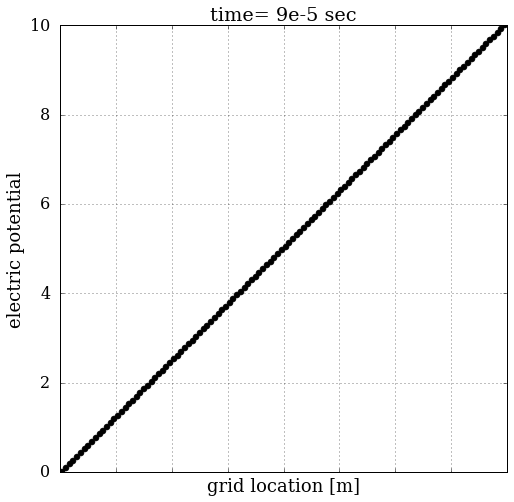

In [128]:
plot( xc,phis[0][1:-1], 'grid location [m]','electric potential',  'time= 9e-5 sec')

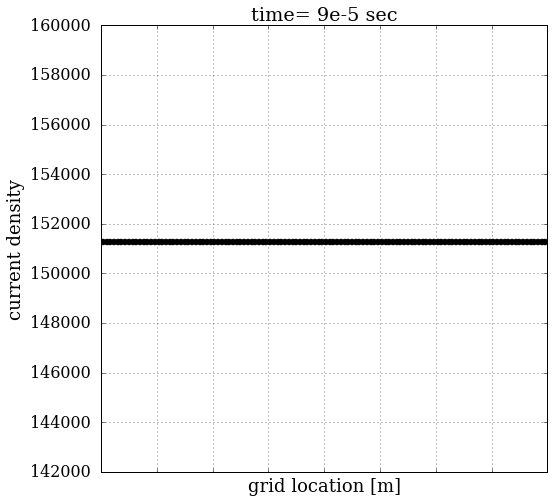

In [129]:
plot( xc, numpy.round(js[0][1:-1], decimals=4), 'grid location [m]','current density',  'time= 9e-5 sec')

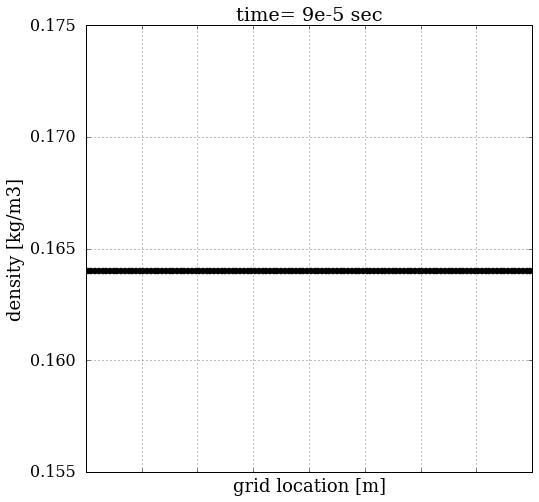

In [130]:
plot( xc, numpy.round(rhos[0][1:-1], decimals=4), 'grid location [m]','density [kg/m3]',  'time= 9e-5 sec')

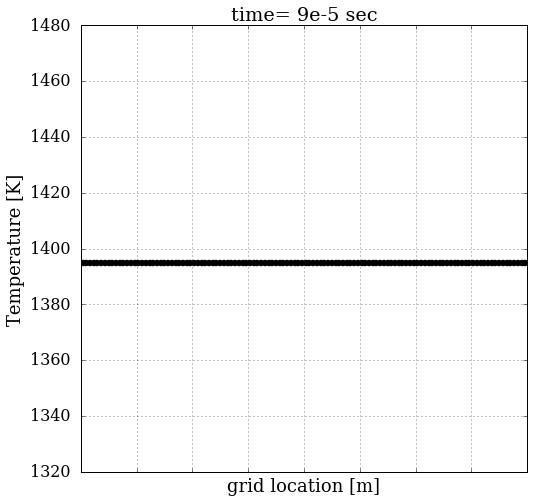

In [131]:
plot( xc,numpy.round(Ts[0][1:-1], decimals=4), 'grid location [m]','Temperature [K]',  'time= 9e-5 sec')

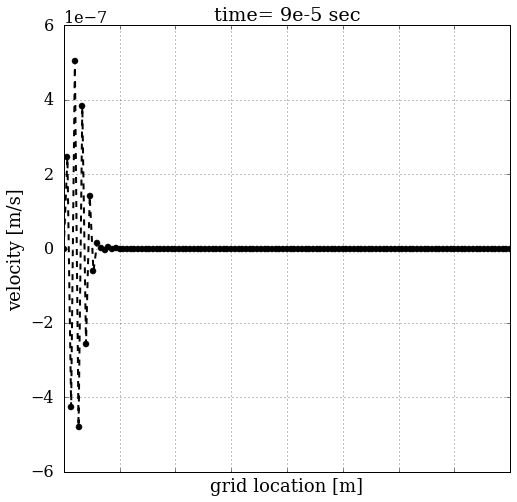

In [132]:
plot( xb,numpy.round(us[0][1:-1], decimals=20), 'grid location [m]','velocity [m/s]',  'time= 9e-5 sec')

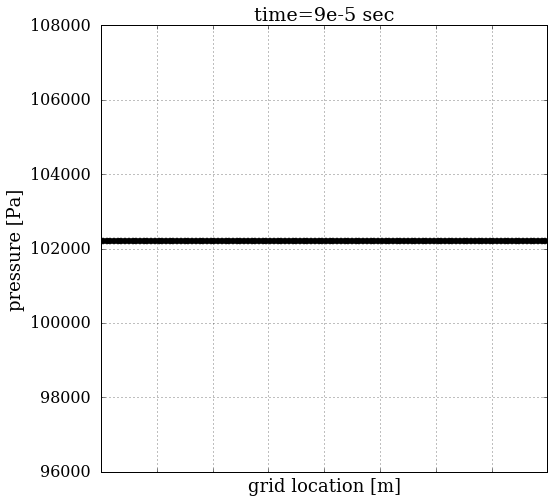

In [133]:
plot( xc,ps[0][1:-1], 'grid location [m]','pressure [Pa]',  'time=9e-5 sec')

## intermediate time

In [134]:
test = numpy.zeros_like(Ts)
array_size = numpy.size(test[:,0])
mid_time = int(array_size/2)

In [135]:
ctime[mid_time]

0.015089999999999751

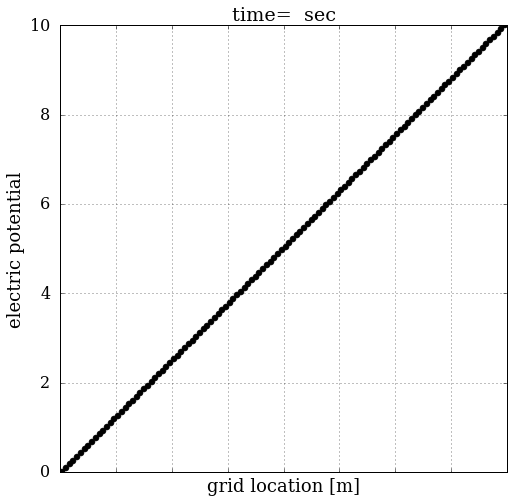

In [136]:
plot( xc,phis[mid_time][1:-1], 'grid location [m]','electric potential',  'time=  sec')

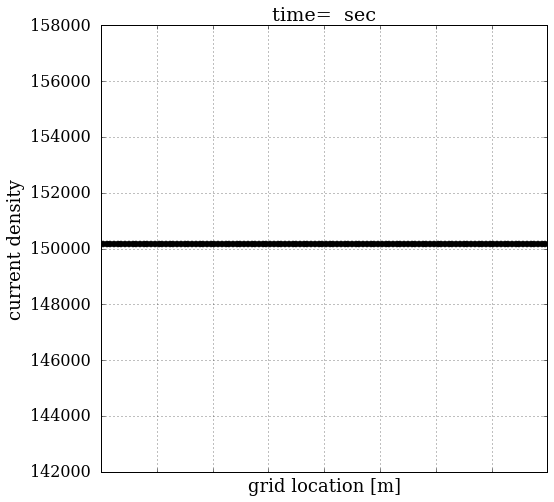

In [137]:
plot( xc,numpy.round(js[mid_time][1:-1]), 'grid location [m]','current density',  'time=  sec')

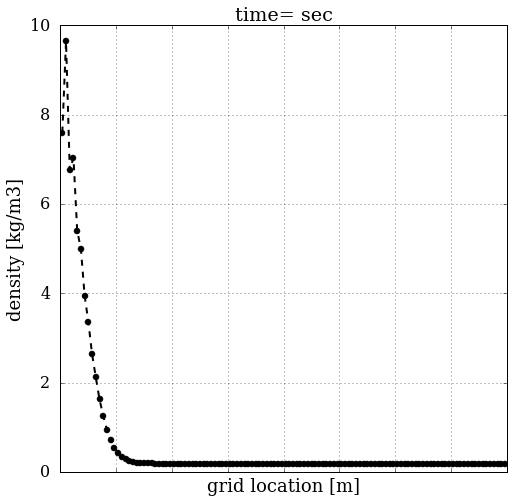

In [138]:
plot( xc,numpy.round(rhos[mid_time][1:-1],decimals=10), 'grid location [m]','density [kg/m3]',  'time= sec')

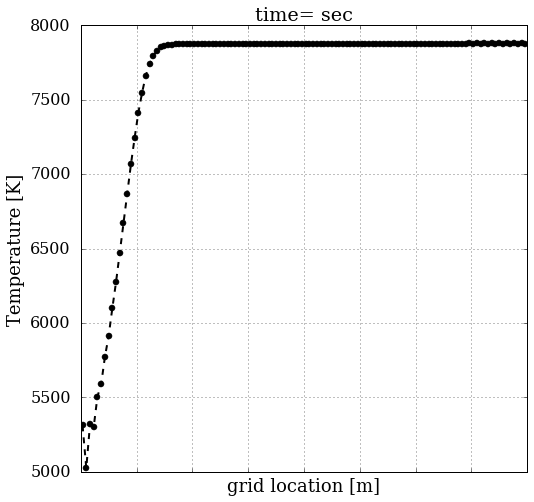

In [139]:
plot( xc,numpy.round(Ts[mid_time][1:-1],decimals=10), 'grid location [m]','Temperature [K]',  'time= sec')

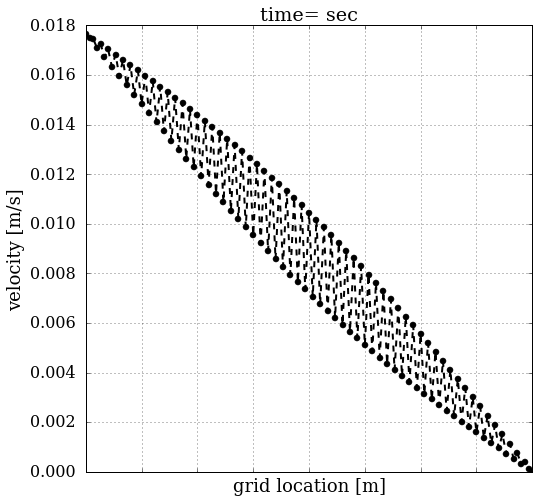

In [140]:
plot( xb,numpy.round(us[mid_time][1:-1], decimals=10), 'grid location [m]','velocity [m/s]',  'time= sec')

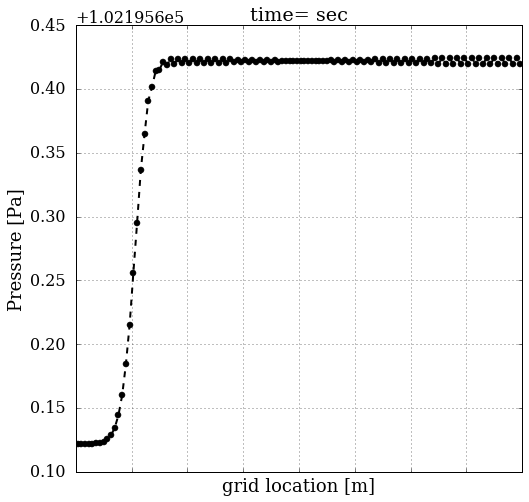

In [141]:
plot( xc,ps[mid_time][1:-1], 'grid location [m]','Pressure [Pa]',  'time= sec')

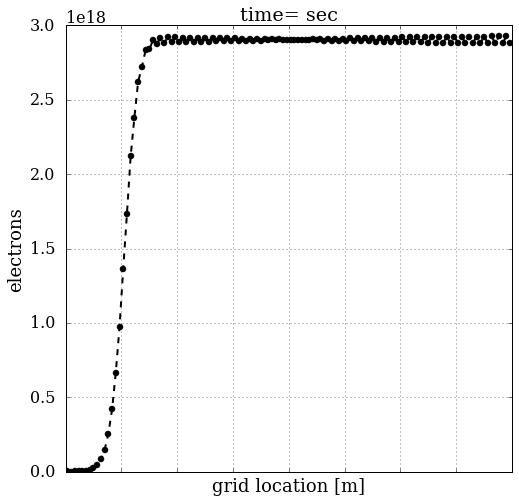

In [142]:
plot( xc,nes[mid_time][1:-1], 'grid location [m]','electrons',  'time= sec')

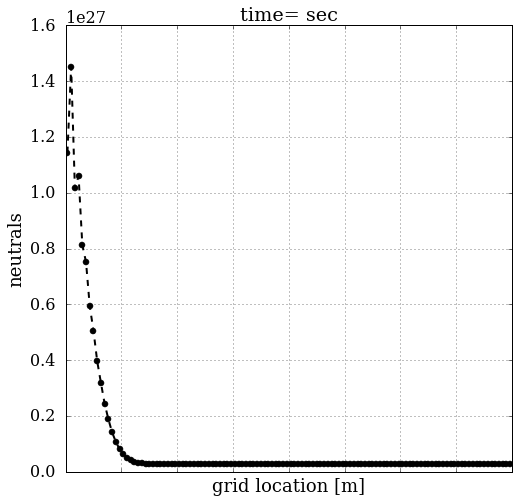

In [143]:
plot( xc, numpy.round(nos[mid_time][1:-1], decimals=25), 'grid location [m]','neutrals',  'time= sec')

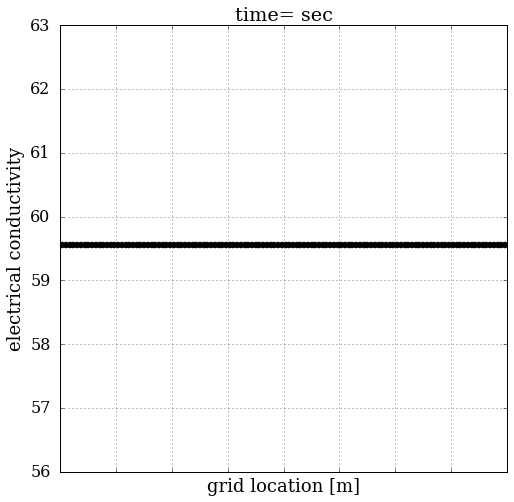

In [144]:
plot( xc,econds[mid_time][1:-1], 'grid location [m]','electrical conductivity',  'time= sec')

## final time

In [145]:
numpy.shape(phis)

(400, 122)

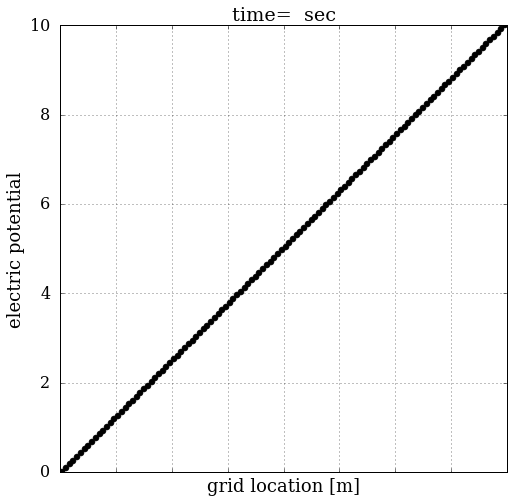

In [146]:
plot( xc,phis[-1][1:-1], 'grid location [m]','electric potential',  'time=  sec')

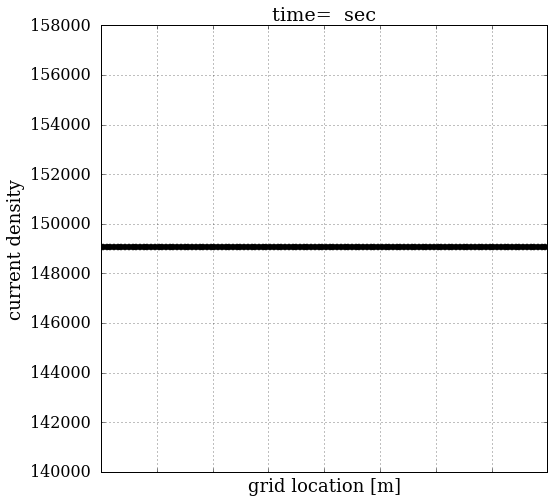

In [147]:
plot( xc, numpy.round(js[-1][1:-1]), 'grid location [m]','current density',  'time=  sec')

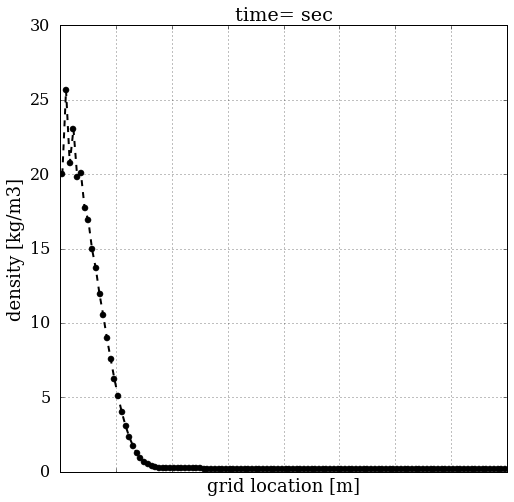

In [148]:
plot( xc,numpy.round(rhos[-1][1:-1], decimals=10), 'grid location [m]','density [kg/m3]',  'time= sec')

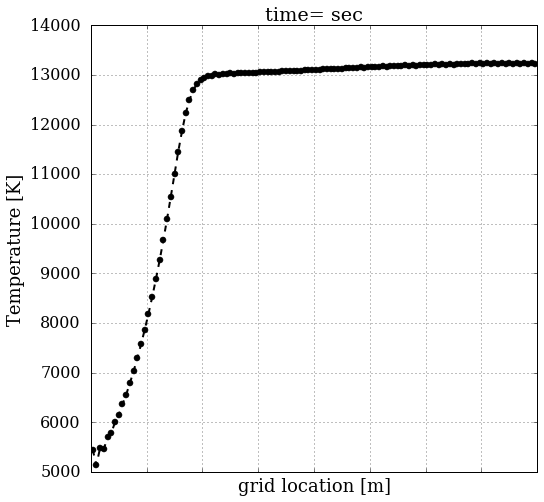

In [149]:
plot( xc,numpy.round(Ts[-1][1:-1],decimals=4), 'grid location [m]','Temperature [K]',  'time= sec')

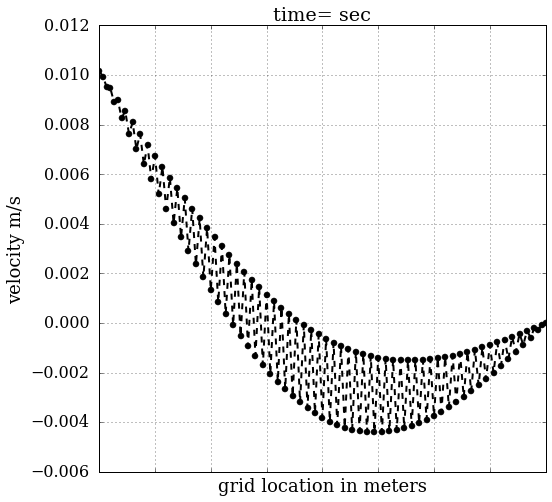

In [150]:
plot( xb,numpy.round(us[-1][1:-1],decimals=10), 'grid location in meters','velocity m/s',  'time= sec')

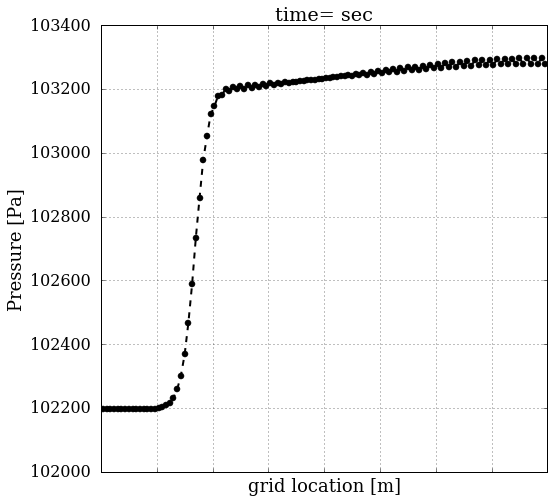

In [151]:
plot( xc,numpy.round(ps[-1][1:-1]), 'grid location [m]','Pressure [Pa]',  'time= sec')

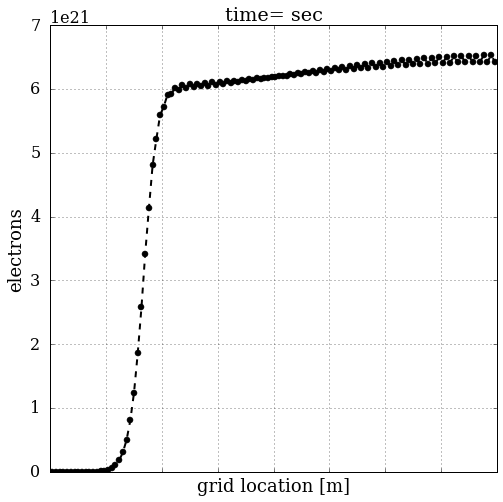

In [152]:
plot( xc,nes[-1][1:-1], 'grid location [m]','electrons',  'time= sec')

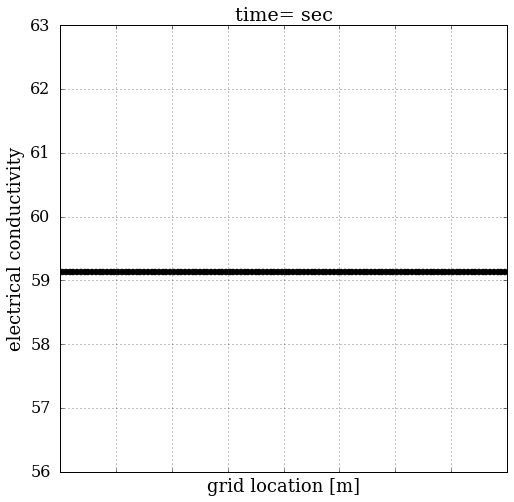

In [153]:
plot( xc,econds[-1][1:-1], 'grid location [m]','electrical conductivity',  'time= sec')

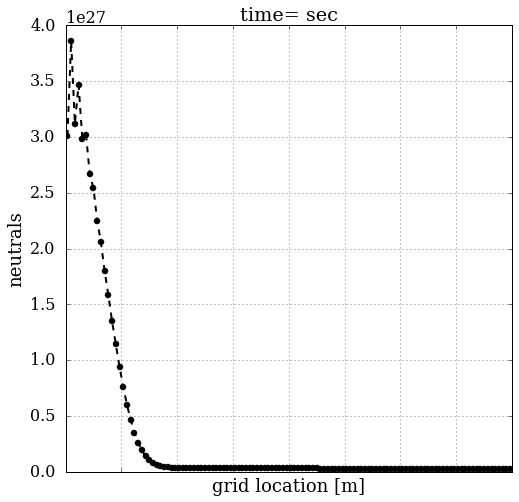

In [154]:
plot( xc,numpy.round(nos[-1][1:-1]), 'grid location [m]','neutrals',  'time= sec')

## Animation

In [155]:
from matplotlib import animation
from JSAnimation import IPython_display
from JSAnimation.IPython_display import display_animation
from moviepy.editor import *

import pylab 
import types

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [174]:
time_domain = numpy.size(ctime)
space_domain = numpy.size(xb)
space_domain2 = numpy.size(xc)
US = numpy.zeros((time_domain, space_domain), dtype=float)
TS = numpy.zeros((time_domain, space_domain2), dtype=float)
NES = numpy.zeros((time_domain, space_domain2), dtype=float)
RHOS = numpy.zeros((time_domain, space_domain2), dtype=float)
#
for i in range(time_domain):
    US[i,:] = us[i][1:-1]
    TS[i,:] = Ts[i][1:-1]
    NES[i,:] = nes[i][1:-1]
    RHOS[i,:] = rhos[i][1:-1]

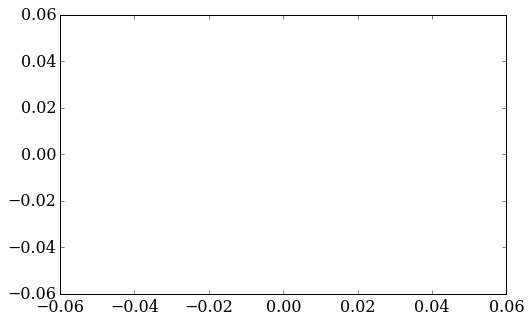

In [175]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes()
im = ax.plot([], [], color='b', ls='--', lw=3)

In [176]:
def animate(data):
    im = ax.plot(xb,data, color='b', ls='--', lw=3)
    return im

In [177]:
def animate2(data):
    im = ax.plot(xc,data, color='b', ls='--', lw=3)
    return im

In [178]:
anim = animation.FuncAnimation(fig, animate2, frames=NES[1:-1:10,:], interval=200)

In [179]:
#display_animation(anim, default_mode='once')

In [180]:
#anim.save("1D_ABL_rho_1000ts.mp4", writer='ffmpeg')
#anim.save("1D_ABL_Ts_1000ts.mp4", writer='ffmpeg')
#anim.save("1D_ABL_Us_1000ts.mp4", writer='ffmpeg')
anim.save("1D_ABL_NES_1000ts.mp4", writer='ffmpeg')